In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import casacore
import casacore.tables as pt
import pandas as pd
from sklearn import cluster
from sklearn import metrics
plt.rcParams['figure.figsize']=[10,8]
plt.rcParams['font.size']=14

#fname = "/data001/scratch/kkozarev/EVENT_20170804/MS/SUN/L602826_SAP000_SB052_uv_autoweight.MS"
basedir='/data/LOFAR/20170804/'
fname = basedir+"L602826_SAP000_SB154_uv_autoweight.MS"
savedir=basedir+'viscutoff/'

In [4]:
ant = pt.table(fname+"/ANTENNA").getcol("NAME")
cs = [i for i,j in enumerate(ant) if "CS" in j] #only collect data of CS for now

Successful readonly open of default-locked table /data/LOFAR/20170804/L602826_SAP000_SB154_uv_autoweight.MS/ANTENNA: 10 columns, 35 rows


In [58]:
myt = pt.taql("select from $fname where ANTENNA1==0 and ANTENNA2==1")

In [59]:
uvw=myt.getcol("UVW")
corrected_datacol = myt.getcol("CORRECTED_DATA")
flags = myt.getcol("FLAG")


In [71]:
uvw[0:10,:]

array([[  47.55830809,  343.93719573, -270.55600601],
       [  47.55174324,  343.93744492, -270.55684311],
       [  47.54517837,  343.93769409, -270.55768009],
       [  47.53861351,  343.93794321, -270.55851696],
       [  47.53204859,  343.93819231, -270.55935372],
       [  47.52548368,  343.93844136, -270.56019037],
       [  47.51891878,  343.93869039, -270.56102689],
       [  47.5123538 ,  343.93893937, -270.56186331],
       [  47.50578887,  343.93918832, -270.5626996 ],
       [  47.49922388,  343.93943724, -270.56353579]])

In [75]:
np.linalg.norm(uvw[:,:],axis=1)

array([440.17625976, 440.17625976, 440.17625976, ..., 440.17625976,
       440.17625976, 440.17625976])

In [5]:
#Develop pandas dataframes for each cross-correlation before and after calibration
#They hold the visibility amplitudes for all LOFAR baselines over all timesteps of observation.
blines = []
#ONLY FOR XX
dfxx = pd.DataFrame()
cdfxx = pd.DataFrame()
fdfxx = pd.DataFrame()
dfxx_test = pd.DataFrame()
for idx1,ant1 in enumerate(cs):
    for ant2 in cs[idx1+1:]:
        column=ant[ant1]+"_"+ant[ant2]
        blines.append(column)
        myt = pt.taql("select from $fname where ANTENNA1==$ant1 and ANTENNA2==$ant2")
        flags = myt.getcol("FLAG")
        datacol = myt.getcol("DATA")
        corrected_datacol = myt.getcol("CORRECTED_DATA")
        uvw=myt.getcol("UVW")
        fdfxx[column]=flags[:,0,0]
        cdfxx[column]=np.abs(np.ma.array(corrected_datacol[:,0,0], mask=flags[:,0,0])).astype(np.float32)
        dfxx[column]=np.abs(np.ma.array(corrected_datacol[:,0,0], mask=flags[:,0,0])).astype(np.float32)
        dfxx_test[column+'_data_real']=np.ma.array(datacol[:,0,0].real, mask=flags[:,0,0])
        dfxx_test[column+'_data_imag']=np.ma.array(datacol[:,0,0].imag, mask=flags[:,0,0])
        dfxx_test[column+'_corrdata_real']=np.ma.array(corrected_datacol[:,0,0].real, mask=flags[:,0,0])
        dfxx_test[column+'_corrdata_imag']=np.ma.array(corrected_datacol[:,0,0].imag, mask=flags[:,0,0])
        dfxx_test[column+'_u']=np.ma.array(uvw[:,0], mask=flags[:,0,0])
        dfxx_test[column+'_v']=np.ma.array(uvw[:,1], mask=flags[:,0,0])
        dfxx_test[column+'_w']=np.ma.array(uvw[:,2], mask=flags[:,0,0])
        tmp=np.ma.array(uvw[:,2], mask=flags[:,0,0])
        #dfxx_test[column+'_r']=
#Flag column dataframes
fdfxx.to_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_fxx.p')
#Data column dataframes
cdfxx.to_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_cdxx.p')
#Corrected data column dataframes
dfxx.to_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_dxx.p')
dfxx_test.to_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_dxx_test.p')

In [91]:
cols_v=[col for col in dfxx_test.columns if '_v' in col]
cols_u=[col for col in dfxx_test.columns if '_u' in col]
cols_w=[col for col in dfxx_test.columns if '_w' in col]
cols_cdr=[col for col in dfxx_test.columns if '_corrdata_real' in col]
cols_cdi=[col for col in dfxx_test.columns if '_corrdata_imag' in col]
dr=np.sqrt(dfxx_test[cols_v[0]]*dfxx_test[cols_v[0]]+dfxx_test[cols_u[0]]*dfxx_test[cols_u[0]]+dfxx_test[cols_w[0]]*dfxx_test[cols_w[0]])


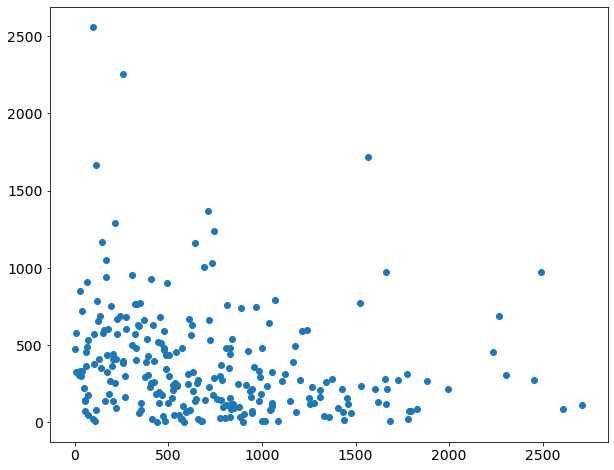

In [96]:
plt.scatter(np.abs(dfxx_test[cols_u].iloc[0]),np.abs(dfxx_test[cols_cdi].iloc[0]))

In [153]:
#Develop pandas dataframes for each cross-correlation before and after calibration
#They hold the visibility amplitudes for all LOFAR baselines over all timesteps of observation.
blines = []
#XX,XY,YX,YY
dfxx = pd.DataFrame()
dfxy = pd.DataFrame()
dfyx = pd.DataFrame()
dfyy = pd.DataFrame()
cdfxx = pd.DataFrame()
cdfxy = pd.DataFrame()
cdfyx = pd.DataFrame()
cdfyy = pd.DataFrame()
fdfxx = pd.DataFrame() 
fdfxy = pd.DataFrame() 
fdfyx = pd.DataFrame()
fdfyy = pd.DataFrame() 
for idx1,ant1 in enumerate(cs):
    for ant2 in cs[idx1+1:]:
        column=ant[ant1]+"_"+ant[ant2]
        blines.append(column)
        myt = pt.taql("select from $fname where ANTENNA1==$ant1 and ANTENNA2==$ant2")
        flags = myt.getcol("FLAG")
        datacol = myt.getcol("DATA")
        corrected_datacol = myt.getcol("CORRECTED_DATA")
        fdfxx[column]=flags[:,0,0]
        fdfxy[column]=flags[:,0,1]
        fdfyx[column]=flags[:,0,2]
        fdfyy[column]=flags[:,0,3]
        cdfxx[column]=np.ma.array(corrected_datacol[:,0,0], mask=flags[:,0,0])
        #dfxx[column]=np.abs(np.ma.array(datacol[:,0,0], mask=flags[:,0,0])).astype(np.float32)
        cdfxy[column]=np.abs(np.ma.array(corrected_datacol[:,0,1], mask=flags[:,0,1])).astype(np.float32)
        #dfxy[column]=np.abs(np.ma.array(datacol[:,0,1], mask=flags[:,0,1])).astype(np.float32)
        cdfyx[column]=np.abs(np.ma.array(corrected_datacol[:,0,2], mask=flags[:,0,2])).astype(np.float32)
        #dfyx[column]=np.abs(np.ma.array(datacol[:,0,2], mask=flags[:,0,2])).astype(np.float32)
        cdfyy[column]=np.abs(np.ma.array(corrected_datacol[:,0,3], mask=flags[:,0,3])).astype(np.float32)
        #dfyy[column]=np.abs(np.ma.array(datacol[:,0,3], mask=flags[:,0,3])).astype(np.float32)

#Flag column dataframes
fdfxx.to_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_fxx.p')     
fdfxy.to_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_fxy.p') 
fdfyx.to_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_fyx.p') 
fdfyy.to_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_fyy.p')
#Corrected data column dataframes
cdfxx.to_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_cdxx.p')
cdfxy.to_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_cdxy.p')
cdfyx.to_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_cdyx.p')
cdfyy.to_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_cdyy.p')
#Data column dataframes
dfxx.to_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_dxx.p')
dfxy.to_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_dxy.p')
dfyx.to_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_dyx.p')
dfyy.to_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_dyy.p')

KeyboardInterrupt: 

In [188]:
myt = pt.taql("select from $fname where (ANTENNA1 < 23) and (ANTENNA2 < 23) and (ANTENNA1 != ANTENNA2)")
flags = myt.getcol("FLAG")

In [187]:
myt
#flags.shape

In [ ]:
#SECOND, OPTIMIZED VERSION

#Develop pandas dataframes for each cross-correlation before and after calibration
#They hold the visibility amplitudes for all LOFAR baselines over all timesteps of observation.
blines = []
#XX,XY,YX,YY
dfxx = pd.DataFrame()
dfxy = pd.DataFrame()
dfyx = pd.DataFrame()
dfyy = pd.DataFrame()
cdfxx = pd.DataFrame()
cdfxy = pd.DataFrame()
cdfyx = pd.DataFrame()
cdfyy = pd.DataFrame()
fdfxx = pd.DataFrame() 
fdfxy = pd.DataFrame() 
fdfyx = pd.DataFrame()
fdfyy = pd.DataFrame() 
for idx1,ant1 in enumerate(cs):
    for ant2 in cs[idx1+1:]:
        column=ant[ant1]+"_"+ant[ant2]
        blines.append(column)
        myt = pt.taql("select from $fname where ANTENNA1==$ant1 and ANTENNA2==$ant2")
        flags = myt.getcol("FLAG")
        datacol = myt.getcol("DATA")
        corrected_datacol = myt.getcol("CORRECTED_DATA")
        fdfxx[column]=flags[:,0,0]
        fdfxy[column]=flags[:,0,1]
        fdfyx[column]=flags[:,0,2]
        fdfyy[column]=flags[:,0,3]
        cdfxx[column]=np.ma.array(corrected_datacol[:,0,0], mask=flags[:,0,0])
        dfxx[column]=np.ma.array(datacol[:,0,0], mask=flags[:,0,0])
        cdfxy[column]=np.ma.array(corrected_datacol[:,0,1], mask=flags[:,0,1])
        dfxy[column]=np.ma.array(datacol[:,0,1], mask=flags[:,0,1])
        cdfyx[column]=np.ma.array(corrected_datacol[:,0,2], mask=flags[:,0,2])
        dfyx[column]=np.ma.array(datacol[:,0,2], mask=flags[:,0,2])
        cdfyy[column]=np.ma.array(corrected_datacol[:,0,3], mask=flags[:,0,3])
        dfyy[column]=np.ma.array(datacol[:,0,3], mask=flags[:,0,3])

#Flag column dataframes
fdfxx.to_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_fxx.p')     
fdfxy.to_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_fxy.p') 
fdfyx.to_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_fyx.p') 
fdfyy.to_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_fyy.p')
#Data column dataframes
cdfxx.to_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_cdxx.p')
cdfxy.to_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_cdxy.p')
cdfyx.to_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_cdyx.p')
cdfyy.to_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_cdyy.p')
#Corrected data column dataframes
dfxx.to_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_dxx.p')
dfxy.to_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_dxy.p')
dfyx.to_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_dyx.p')
dfyy.to_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_dyy.p')

In [22]:
#SECOND, OPTIMIZED VERSION

#Develop pandas dataframes for each cross-correlation before and after calibration
#They hold the visibility amplitudes for all LOFAR baselines over all timesteps of observation.
blines = []
#XX,XY,YX,YY
dfxx = pd.DataFrame()
cdfxx = pd.DataFrame()
fdfxx = pd.DataFrame()
blxx = pd.DataFrame()
for idx1,ant1 in enumerate(cs):
    for ant2 in cs[idx1+1:]:
        column=ant[ant1]+"_"+ant[ant2]
        blines.append(column)
        myt = pt.taql("select from $fname where ANTENNA1==$ant1 and ANTENNA2==$ant2")
        uvw=myt.getcol("UVW")
        flags = myt.getcol("FLAG")
        datacol = myt.getcol("DATA")
        corrected_datacol = myt.getcol("CORRECTED_DATA")
        fdfxx[column]=flags[:,0,0]
        cdfxx[column]=np.ma.array(corrected_datacol[:,0,0], mask=flags[:,0,0])
        dfxx[column]=np.ma.array(datacol[:,0,0], mask=flags[:,0,0])
        blxx[column]=np.linalg.norm(uvw,axis=1)
        

#Flag column dataframes
fdfxx.to_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_fxx.p') 
#Data column dataframes
cdfxx.to_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_cdxx.p')
#Corrected data column dataframes
dfxx.to_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_dxx.p')
#Baselines dataframe
blxx.to_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_blxx.p')

In [45]:
cdfxx=pd.read_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_cdxx.p')

In [70]:
cdfxx

CS001LBA_CS002LBA           CS001LBA_CS003LBA  \
0      1.850123e+03+2.198991e+02j  1.244025e+03+1.461868e+02j   
1      1.617636e+03+1.831264e+02j  1.219096e+03+4.567508e+01j   
2      1.917096e+03+4.371227e+02j  1.619826e+03+4.632457e+02j   
3      2.076030e+03+6.351196e+01j  1.343642e+03+1.470404e+02j   
4      1.609542e+03+2.238363e+02j  1.346395e+03+1.965465e+02j   
...                           ...                         ...   
57515 -1.063020e+07+3.139850e+07j  1.922376e+07+2.980116e+07j   
57516  3.591205e+06+2.104779e+07j  2.016148e+07+3.671554e+06j   
57517 -2.708594e+07+2.905399e+07j -2.320683e+06-6.267997e+06j   
57518 -1.222575e+07+2.784033e+07j  9.582060e+06+8.752621e+06j   
57519  8.475271e+06+4.922589e+07j  1.580326e+07+7.337832e+06j   

                CS001LBA_CS004LBA           CS001LBA_CS005LBA  \
0      2.626029e+03+3.074925e+02j  2.483041e+03+1.023302e+01j   
1      2.530693e+03+3.429550e+02j  2.698259e+03+1.145996e+01j   
2      2.672936e+03+3.968889e+02j  2.604865e+03-2.284158e+01j   
3      2.802084e+03+2.767251e+02j  2.754902e+03-1.341881e+02j   
4      2.523527e+03+3.733228e+02j  2.679134e+03+2.292714e+02j   
...                           ...                         ...   
57515  2.876540e+07-4.314979e+07j  4.729128e+07-4.199124e+07j   
57516  3.690343e+07+3.758854e+05j  7.092320e+07-4.536146e+07j   
57517  4.191401e+07-1.487987e+07j  4.995268e+07-4.237562e+07j   
57518  1.420052e+07-4.766844e+07j  5.358418e+07-4.329957e+07j   
57519  2.338032e+07-3.560203e+07j  6.447829e+07-2.049385e+07j   

                CS001LBA_CS006LBA           CS001LBA_CS007LBA  \
0      1.254713e+03-4.364033e+02j  1.686798e+03-7.941423e+01j   
1      1.466371e+03-1.936111e+02j  1.475356e+03-3.552054e+02j   
2      1.476390e+03-4.245202e+02j  1.306384e+03-3.429864e+02j   
3      1.717916e+03-1.808219e+02j  1.378201e+03-1.998345e+02j   
4      1.577185e+03-2.162251e+02j  1.513715e+03-9.836417e+01j   
...                           ...                         ...   
57515  6.429937e+07-2.493925e+06j  3.735409e+07+1.110234e+06j   
57516  5.668236e+07-1.710473e+07j  4.906102e+07+4.931184e+06j   
57517  5.763498e+07-1.068630e+07j  2.837391e+07+1.345442e+07j   
57518  4.061734e+07-3.214236e+07j  4.574736e+07-1.390413e+07j   
57519  5.411960e+07-1.008557e+07j  4.545480e+07+2.428316e+06j   

                CS001LBA_CS011LBA           CS001LBA_CS013LBA  \
0      6.313000e+02-7.632696e+02j  4.975782e+02+9.094180e+01j   
1      1.133482e+03-5.781484e+02j  5.132852e+02+3.957290e+02j   
2      8.300740e+02-6.810862e+02j  7.550021e+02+3.013870e+02j   
3      1.184136e+03-8.736765e+02j  1.122662e+03+2.162242e+02j   
4      8.399744e+02-7.305927e+02j  7.568474e+02+8.303114e+02j   
...                           ...                         ...   
57515  7.155921e+07-5.380069e+07j -1.991998e+06+2.279405e+07j   
57516  7.003246e+07-2.355794e+07j  5.252746e+06+3.084608e+07j   
57517  5.041260e+07-2.835752e+07j  2.298805e+07+2.538134e+07j   
57518  5.122183e+07-4.260775e+07j  1.841526e+06+1.383194e+07j   
57519  5.230226e+07-6.665995e+07j -6.136907e+06+4.984328e+07j   

                CS001LBA_CS017LBA           CS001LBA_CS021LBA  ...  \
0     -2.963153e+02-1.238562e+02j -2.112775e+02-5.159567e+02j  ...   
1     -2.191439e+02-2.025168e+02j  1.979326e+02-6.724580e+02j  ...   
2     -3.141461e+02+1.526134e+01j  2.661337e+02-2.497082e+02j  ...   
3     -3.630674e+02+6.057641e+01j  8.309512e+01-6.223694e+02j  ...   
4     -4.315768e+02-1.013560e+02j  2.697130e+02-4.038018e+02j  ...   
...                           ...                         ...  ...   
57515  2.349330e+07+1.092980e+07j  1.958108e+07+1.234637e+07j  ...   
57516  2.686097e+07-1.520200e+07j -7.168733e+06-2.187272e+07j  ...   
57517  2.299392e+06+5.386226e+06j -8.950696e+06-1.908111e+07j  ...   
57518  2.130478e+06+9.144991e+06j  6.368466e+06-3.431478e+07j  ...   
57519  2.667895e+07-2.278585e+07j  1.089169e+07-1.223205e+07j  ...   

                CS103LBA_CS201LBA           CS103LB

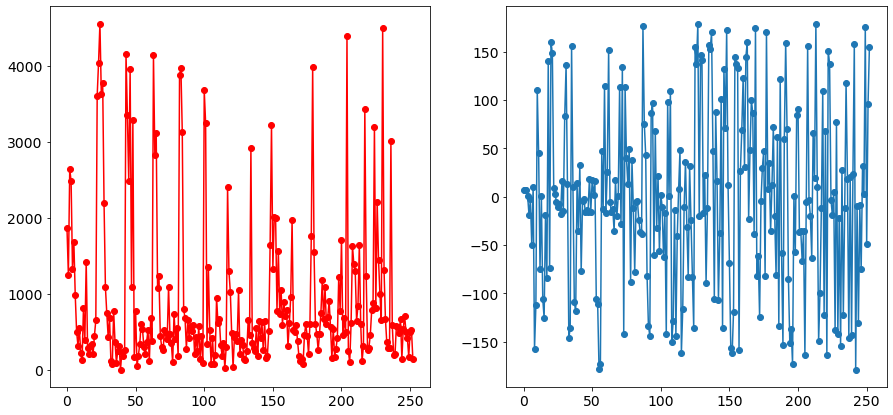

In [86]:
#Plot the amplitude and phase of the visibilities for a single timestep
timeind=0
fig=plt.figure(figsize=(15,7))
#Plot the magnitude of the XX observations
ax1 = fig.add_subplot(121)
ax1.plot(np.abs(cdfxx.loc[timeind].values),marker='o',color='red')
#Plot the phase angle of the XX observations
ax2 = fig.add_subplot(122)
ax2.plot(np.angle(cdfxx.loc[timeind].values,deg=True),marker='o')

(-50, 50)

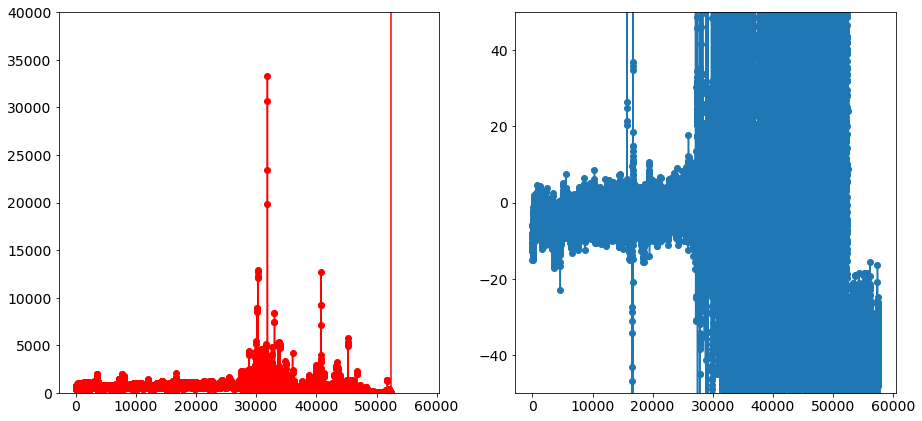

In [101]:
#Plot the mean amplitude and phase of the visibilities for all timesteps
cdfxxmean=cdfxx.mean(axis=1).values
fig=plt.figure(figsize=(15,7))
#Plot the magnitude of the XX observations
ax1 = fig.add_subplot(121)
ax1.plot(np.abs(cdfxxmean),marker='o',color='red')
ax1.set_ylim(0,4.e4)
#Plot the phase angle of the XX observations
ax2 = fig.add_subplot(122)
ax2.plot(np.angle(cdfxxmean,deg=True),marker='o')
ax2.set_ylim(-50,50)

(57520, 253)

In [27]:
### Loop over all intervals/timesteps, and do K-Means clustering over all baselines
#The code below only does it for the magnitudes of the XX correlations
cdfxx=pd.read_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_cdxx.p')
vmax=[]
for tt in range(ntimes):
    data = np.abs(cdfxx.loc[tt].values.reshape(-1, 1)).astype(np.float32)
    kmeans=cluster.KMeans(n_clusters=5)
    model=kmeans.fit(data)
    # Get cluster assignment labels
    labels = kmeans.labels_
    # Format results as a DataFrame
    #results = pd.DataFrame([labels]).T
    #u_labels = np.unique(results[1].values)
    cluster_centers = kmeans.cluster_centers_
    u_labels=cluster_centers[:,0].argsort()
    #Metrics scores
    #sscore=metrics.silhouette_score(data, labels, metric = 'euclidean')
    #chscore=metrics.calinski_harabasz_score(data, labels)
    #Record the cut-offs
    vmax.append(np.nanmax(data[labels == u_labels[1]]))
vdf=pd.DataFrame(vmax)
vdf.to_pickle(savedir+'visibility_cutoff_xx.p')

NameError: name 'ntimes' is not defined

In [94]:
#UPDATE THE FLAG TABLE OF THE MS DATA BASED ON THE VIS MAGNITUDE CUT-OFFS - ONLY FOR XX correlation

#Set this to True to do the update
update_MS_flags = False

if update_MS_flags:
    vmax=pd.read_pickle(savedir+'visibility_cutoff_xx.p')
    ntimes=vmax.shape[0]
    
    # to flag the data you could update the flag column, you might want to keep the old flags however in order to be able to convert back
    myt = pt.table(fname,readonly=False)
    flags = myt.getcol("FLAG")
    desc=myt.getcoldesc("FLAG")
    cdata = myt.getcol("CORRECTED_DATA")
    
    newflags=flags.copy()
    stride=630 #the number of antenna station combinations in this MS
    #Apply time-dependent cut-off flagging
    for tt in range(ntimes):
        newflags[tt*stride:(tt+1)*stride,0,0] = np.abs(cdata[tt*stride:(tt+1)*stride,0,0]) > vmax.values[tt][0]
    newflags = np.logical_or(flags,newflags)
    if "OLDFLAGS" in myt.colnames():
        print ("column OLDFLAGS already existing, not overwriting")
    else:
       desc['name']="OLDFLAGS"
       myt.addcols(desc)
       myt.putcol("OLDFLAGS",flags)
       myt.putcol("FLAG",newflags)
    myt.close()

Successful read/write open of default-locked table /data/L602826_SAP000_SB154_uv_autoweight_test.MS: 27 columns, 36237600 rows


<ipython-input-168-de7a0f164705>:16: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('./visibility_amplitudes.png',bbox_inches='tight')
/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


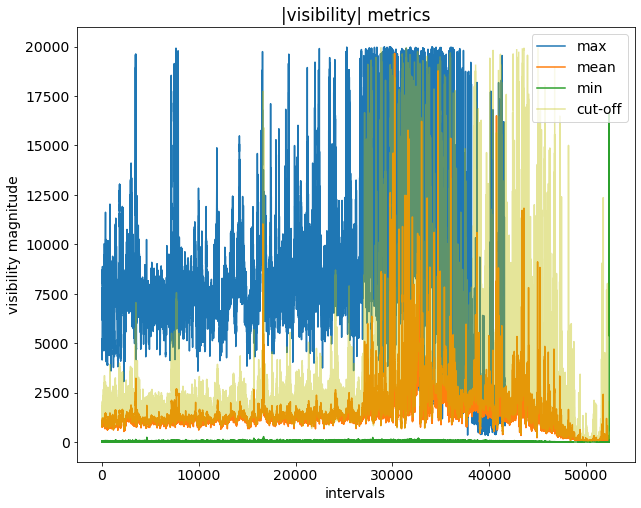

In [168]:
#Plot the |Vis| minimum,mean,maximum, and cut-offs - ONLY FOR XX
vmax=pd.read_pickle(savedir+'/visibility_cutoff_xx.p')
cdfxx=np.abs(pd.read_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_cdxx.p')).astype(np.float32)
origmax=cdfxx.max(axis=1).values
origmean=cdfxx.mean(axis=1).values
origmin=cdfxx.min(axis=1).values
plt.figure(figsize=[10,8])
plt.plot(origmax[origmax < 2.e4],label='max')
plt.plot(origmean[origmean < 2.e4],label='mean')
plt.plot(origmin[origmin < 2.e4],label='min')
plt.plot(vmax[vmax < 2.e4],label='cut-off',alpha=0.5,c='y')
plt.xlabel('intervals')
plt.ylabel('visibility magnitude')
plt.title('|visibility| metrics')
plt.legend()
plt.savefig(savedir+'visibility_amplitudes_XX.png',bbox_inches='tight')

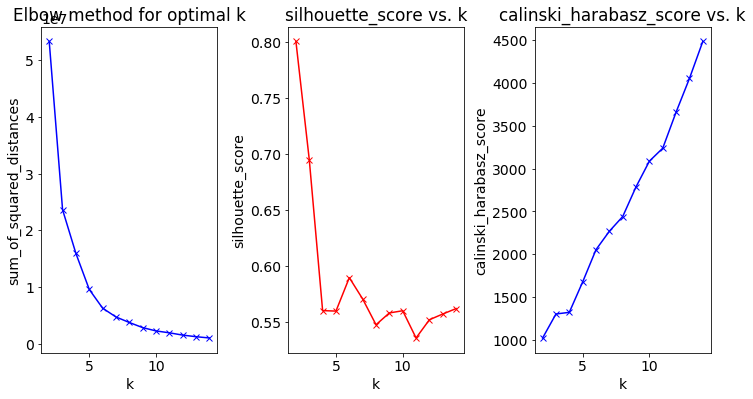

In [173]:
#Recording the metrics for a variety of k-values for comparison - ONLY FOR XX
#for each value of k, we can initialise k_means and use inertia to identify the sum of squared distances of samples to the nearest cluster centre
cdfxx=np.abs(pd.read_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_cdxx.p')).astype(np.float32)
#Do this for a single timestep. The first one is selected here.
tt=0
data = cdfxx.loc[tt].values.reshape(-1, 1)

sum_of_squared_distances = []
chscore = []
sscore = []
K = range(2,15)
for k in K:
    kmeans = cluster.KMeans(n_clusters=k)
    model = kmeans.fit(data)
    labels = kmeans.labels_
    sum_of_squared_distances.append(kmeans.inertia_)
    sscore.append(metrics.silhouette_score(data, labels, metric = 'euclidean'))
    chscore.append(metrics.calinski_harabasz_score(data, labels))

    
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
plt.subplot(131)
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow method for optimal k')
plt.subplot(132)
plt.plot(K, sscore, 'rx-')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('silhouette_score vs. k')
plt.subplot(133)
plt.plot(K, chscore, 'bx-')
plt.xlabel('k')
plt.ylabel('calinski_harabasz_score')
plt.title('calinski_harabasz_score vs. k')
fig.subplots_adjust(wspace=.4)
plt.savefig(savedir+'k_value_comparisons.png',bbox_inches='tight')
plt.show()

253


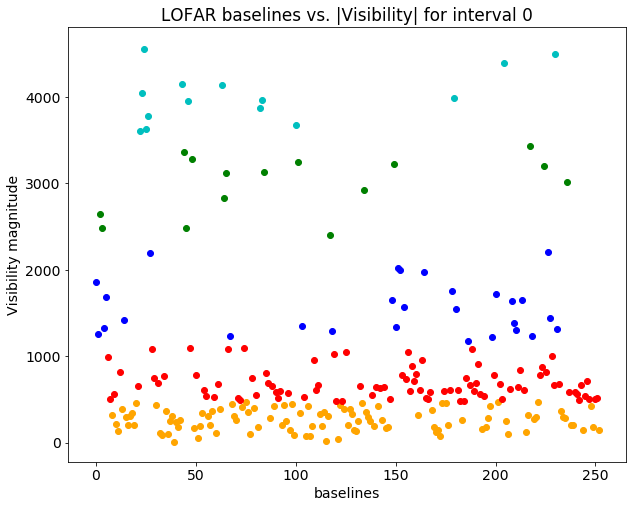

In [172]:
#PLOT THE CLUSTER FOR A SINGLE TIMESTEP
cdfxx=pd.read_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_cdxx.p')
#Do this for a single timestep. The first one is selected here.
tt=0
data = cdfxx.loc[tt].values.reshape(-1, 1)
nbaselines=data.shape[0]
print(nbaselines)
baselines=np.arange(nbaselines)
colors=['r','g','b','orange','c']
kmeans = cluster.KMeans(n_clusters=5)
kmeans.fit(data)
labels = kmeans.labels_

cluster_centers = kmeans.cluster_centers_
u_labels=cluster_centers[:,0].argsort()
for u_label in u_labels:
    plt.scatter(baselines[labels == u_label],data[labels == u_label],c=colors[u_label])
plt.xlabel('baselines')
plt.ylabel('Visibility magnitude')
plt.title('LOFAR baselines vs. |Visibility| for interval {}'.format(tt))
plt.savefig(savedir+'baselines_visibility_clusters.png',bbox_inches='tight')